In [1]:
from pathlib import Path
import time

import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt  # Only for displaying plots
import pandas as pd  # Only for displaying data as tables
import sympy  # Only for displaying rotation matrices

import hilbert_lib

In [2]:
ROOT = Path(".").resolve()

FLIGHT_NAME = "BLC01_132201"

SOLUTION_PATH = ROOT / "20241108123630_GnssImu.sol"
POINTCLOUD_PATH = ROOT / "las_ecef" / f"{FLIGHT_NAME}.las"

# TXT File Exported from Inertial Explorer. Resampled compared to .sol file
# SOLUTION_TXT_PATH = ROOT / "trajectory/Heerbrugg_GNSS-INS_Orientation_correct_precision.txt" 

TIE_POINTS_PATH = ROOT / "tie_points"

In [36]:
# Device Calibration
LIDAR_LEVER_ARM = np.array([0, 0, 0.231])
CAMERA_LEVER_ARM = np.array([0.125, 0, 0.359])
# NIR_CAMERA_LEVER_ARM = np.array([-0.125, 0, 0.359])

DEVICE_MOUNTING_OPK_DEG = np.array([180, 0, 90])

LIDAR_MISALIGNMENT_OPK_DEG = np.array([0.033293, -0.012496, 0.232561])

# RGB: <Misalignment uom="deg" omega="-0.008069" sigmaOmega="0.000118" phi="0.091433" sigmaPhi="0.000114" kappa="-0.052732" sigmaKappa="0.000173"/>
# NIR: <Misalignment uom="deg" omega="-0.061485" sigmaOmega="0.000125" phi="0.009327, " sigmaPhi="0.000121" kappa="-0.052140" sigmaKappa="0.000182"/>
CAMERA_MISALIGNMENT_OPK_DEG = np.array([-0.008069, 0.091433, -0.052732])
CAMERA_UNDOCUMENTED_MISALIGNMENT_OPK_DEG = np.array([0.016054, 0, 0])

# Undistorted camera calibration; uses original dimensions & nominal principal distance
CAMERA_WIDTH = 14192
CAMERA_HEIGHT = 10640
CAMERA_PIXEL_SIZE = 0.00376000
CAMERA_NOMINAL_FOCAL_LENGTH = 45.50000000
CAMERA_MATRIX = np.array([[CAMERA_NOMINAL_FOCAL_LENGTH / CAMERA_PIXEL_SIZE, 0, CAMERA_WIDTH / 2],
                          [0, CAMERA_NOMINAL_FOCAL_LENGTH / CAMERA_PIXEL_SIZE, CAMERA_HEIGHT / 2],
                          [0, 0, 1]])

In [4]:
N_IMAGES = 66

In [5]:
# Transformation from NED (modelling local aircraft coordinates) to ENU (world) coordinate convention
#   NED:  X pointed forward, Y pointed right, Z pointed downwards
#   ENU:  X pointed east,    Y pointed north, Z pointed upwards
#   0 heading, 0 pitch, 0 roll:  aircraft pointed north, right wing pointed east

R_enu_ned = np.array([[0, 1, 0], [1, 0, 0], [0, 0, -1]])

In [6]:
def normalized(p):
    return p / np.linalg.norm(p, axis=-1)[..., np.newaxis]

def multiply_points(matrix, points):
    points = matrix @ points[..., np.newaxis]
    return points[..., 0]

In [7]:
# Simple atmospheric model that has a good match for this dataset.
# Note: it is not the best linear model possible for this dataset, just the one that is roughly fine.

def refractive_index_in_air(altitude):
    return 1 / (0.9997119 + 2.49e-08 * altitude)

def light_speed_in_air(altitude):
    return 299_792_458.0 * (0.9997119 + 2.49e-08 * altitude) 

In [8]:
# While we store point cloud in ECEF, a lot of computations will happen in
# a local coordinate space anchored at the location of trajectory at
# specific timestamp. This local system is defined based on WGS84 Ellipsoid.
#
# In following code, instead of dealing with ellipsoid equations, we just 
# rely on proj4 library and coversions to and from WGS84 coordinates.

def compute_wgs84_up(xyz):
    """Compute up direction as surface normal to the WGS84 Ellipsoid at the input ECEF coordinates."""

    tmp = hilbert_lib.transform_crs(xyz, "ecef", "wgs84")
    tmp[..., 2] += 0.01
    tmp = hilbert_lib.transform_crs(tmp, "wgs84", "ecef")
    tmp[...] -= xyz
    return normalized(tmp)

def compute_base_ecef_rotation(xyz):
    """Compute rotation matrix from ECEF to WGS84/ENU at the input ECEF coordinates."""

    *input_shape, _ = np.shape(xyz)
    ret = np.empty((*input_shape, 3, 3), dtype=np.float64)

    axis_x = ret[..., 0]
    axis_y = ret[..., 1]
    axis_z = ret[..., 2]
    
    axis_z[...] = compute_wgs84_up(xyz)
    axis_x[...] = normalized(np.cross((0, 0, 1), axis_z))
    axis_y[...] = normalized(np.cross(axis_z, axis_x))

    return ret

def compute_wgs84_altitude(xyz):
    return hilbert_lib.transform_crs(xyz, "ecef", "wgs84")[..., 2]

In [9]:
def compute_single_rotation_matrix(angle, axis1, axis2):
    input_shape = np.shape(angle)
    ret = np.empty((*input_shape, 3, 3), dtype=np.float64)
    ret[()] = np.eye(3)
    cos = np.cos(angle)
    sin = np.sin(angle)
    ret[..., axis1, axis1] = cos
    ret[..., axis2, axis2] = cos
    ret[..., axis1, axis2] = -sin
    ret[..., axis2, axis1] = sin
    return ret

def compute_rotation_matrix(rotation, pitch=None, roll=None):
    """Compute rotation matrix from (heading, pitch, roll) or (kappa, phi, omega)."""
    assert (pitch is None) == (roll is None)

    if pitch is None:
        heading = rotation["heading"]
        pitch = rotation["pitch"]
        roll = rotation["roll"]

    else:
        heading = rotation

    return (
        compute_single_rotation_matrix(heading, 0, 1) @
        compute_single_rotation_matrix(pitch, 2, 0) @
        compute_single_rotation_matrix(roll, 1, 2)
    )

# More rotation details

In [10]:
# I believe RPH rotations are equivalent to scipy's `R.from_euler("ZYX", [heading, pitch, roll])`.
test_rph = 0.5, 1.0, 1.5

print(np.amax(abs(
    compute_rotation_matrix(test_rph[2], test_rph[1], test_rph[0]) 
    - R.from_euler("ZYX", [test_rph[2], test_rph[1], test_rph[0]]).as_matrix()
)))

2.7755575615628914e-16


In [11]:
def compute_single_rotation_matrix_sympy(angle, axis1, axis2):
    ret = np.eye(3, dtype=int).tolist()
    ret[axis1][axis1] = sympy.cos(angle)
    ret[axis2][axis2] = sympy.cos(angle)
    ret[axis1][axis2] = -sympy.sin(angle)
    ret[axis2][axis1] = sympy.sin(angle)
    return sympy.Matrix(ret)

heading, pitch, roll = sympy.symbols("H P R")
# heading, pitch, roll = sympy.symbols(R"\kappa \phi \omega")
# heading, pitch, roll = sympy.symbols(R"\psi \theta \phi")

R_heading = compute_single_rotation_matrix_sympy(heading, 0, 1)
R_pitch = compute_single_rotation_matrix_sympy(pitch, 2, 0)
R_roll = compute_single_rotation_matrix_sympy(roll, 1, 2)

sympy.MatMul(R_heading, R_pitch, R_roll)

Matrix([
[cos(H), -sin(H), 0],
[sin(H),  cos(H), 0],
[     0,       0, 1]])*Matrix([
[ cos(P), 0, sin(P)],
[      0, 1,      0],
[-sin(P), 0, cos(P)]])*Matrix([
[1,      0,       0],
[0, cos(R), -sin(R)],
[0, sin(R),  cos(R)]])

In [12]:
R_heading @ R_pitch @ R_roll

Matrix([
[cos(H)*cos(P), -sin(H)*cos(R) + sin(P)*sin(R)*cos(H), sin(H)*sin(R) + sin(P)*cos(H)*cos(R)],
[sin(H)*cos(P),  sin(H)*sin(P)*sin(R) + cos(H)*cos(R), sin(H)*sin(P)*cos(R) - sin(R)*cos(H)],
[      -sin(P),                         sin(R)*cos(P),                        cos(P)*cos(R)]])

In [13]:
# The proper way to implement `compute_base_ecef_rotation` is most likely like this:

def compute_base_ecef_rotation_proper(xyz):
    """Compute rotation matrix from ECEF to WGS84/ENU at the input ECEF coordinates."""
    xyz = hilbert_lib.transform_crs(xyz, "ecef", "wgs84")
    lon = xyz[..., 0]
    lat = xyz[..., 1]

    R1 = compute_single_rotation_matrix(-np.pi / 2, 0, 1)
    R2 = compute_single_rotation_matrix(np.deg2rad(90 - lat), 0, 2)
    R3 = compute_single_rotation_matrix(np.deg2rad(lon), 1, 0)

    return (R1 @ R2 @ R3).T

In [14]:
test_pnt_wgs84 = np.array([9.0, 47.0, 100.0])
test_pnt_ecef = hilbert_lib.transform_crs(test_pnt_wgs84, "wgs84", "ecef")

print(np.amax(abs(compute_base_ecef_rotation_proper(test_pnt_ecef) - compute_base_ecef_rotation(test_pnt_ecef))))

2.562813294915145e-09


In [15]:
# Note: `lat := 90 - lat`, this expression was used to verify consistency with HxMap code.
lon, lat = sympy.symbols("lon lat")
R1 = compute_single_rotation_matrix_sympy(-sympy.pi / 2, 0, 1)
R2 = compute_single_rotation_matrix_sympy(lat, 0, 2)
R3 = compute_single_rotation_matrix_sympy(lon, 1, 0)

R1 @ R2 @ R3

Matrix([
[         -sin(lon),           cos(lon),        0],
[-cos(lat)*cos(lon), -sin(lon)*cos(lat), sin(lat)],
[ sin(lat)*cos(lon),  sin(lat)*sin(lon), cos(lat)]])

# Read trajectory

In [16]:
def data_frame(data):
    """Display array using pandas, with support of structured arrays."""
    columns = []

    for key in data.dtype.fields:
        if len(data[key].shape) == 2:
            n = data[key].shape[1]
            columns.append(pd.DataFrame(data[key], columns=[f"{key}[{i}]" for i in range(n)]))
        else:
            columns.append(pd.DataFrame(data[[key]]))

    return pd.concat(columns, axis=1)

pd.set_option('display.float_format', '{:.6f}'.format)

In [17]:
trajectory = hilbert_lib.read_solution_sol(SOLUTION_PATH, proj="ecef")
data_frame(trajectory)

,xyz[0],xyz[1],xyz[2],time,roll,pitch,heading
0,4260120.275627,694937.983735,4680651.750932,477420.500000,0.009232,0.078802,2.959570
1,4260120.278636,694937.986146,4680651.750174,477420.501175,0.009229,0.078795,2.959545
2,4260120.282138,694937.987596,4680651.746794,477420.503175,0.009230,0.078786,2.959502
3,4260120.285641,694937.989046,4680651.743413,477420.505175,0.009232,0.078777,2.959460
4,4260120.289105,694937.990489,4680651.739986,477420.507175,0.009237,0.078768,2.959417
...,...,...,...,...,...,...,...
2558067,4269053.811935,710225.252196,4672460.457236,482516.493125,-0.033543,-0.091178,-0.874459
2558068,4269053.758569,710225.155590,4672460.515279,482516.495125,-0.033536,-0.091210,-0.874474
2558069,4269053.705203,710225.058983,4672460.573321,482516.497125,-0.033525,-0.091242,-0.874490
2558070,4269053.651837,710224.962375,4672460.631363,482516.499125,-0.033511,-0.091276,-0.874507


In [18]:
R_ecef_device = (
    compute_base_ecef_rotation(trajectory["xyz"]) @  # R_ecef_enu
    R_enu_ned @                                      # R_enu_ned
    compute_rotation_matrix(trajectory)              # R_ned_device
)

camera_lever_arm_in_ecef = R_ecef_device @ CAMERA_LEVER_ARM
lidar_lever_arm_in_ecef = R_ecef_device @ LIDAR_LEVER_ARM

# Cameras

In [19]:
# eop_txt = hilbert_lib.read_eop(ROOT / "eop/eop_ecef.txt", filter_name=FLIGHT_NAME)  # TXT Exported EOPs have limited precision
# data_frame(eop_txt)

In [20]:
# eop_txt2 = hilbert_lib.read_eop(ROOT / "eop/eop_wgs84.txt", filter_name=FLIGHT_NAME, proj="wgs84")  # TXT Exported EOPs have limited precision
# data_frame(eop_txt2)

In [21]:
eop = hilbert_lib.read_eop(ROOT / "eop/ExtOri.gps", mode="lps", proj="wgs84")
# data_frame(eop)

In [22]:
eop_adjusted = hilbert_lib.read_eop(ROOT / "eop/adjusted/ExtOri.gps", mode="lps", proj="wgs84")
# data_frame(eop)

In [23]:
# OPK in export uses different euler convention
def opk2matrix(opk):
    return R.from_euler("zyx", np.stack([opk["kappa"], opk["phi"], opk["omega"]], axis=-1), degrees=True).as_matrix()

eop_rot = opk2matrix(eop)
eop_adjusted_rot = opk2matrix(eop_adjusted)

In [24]:
camera_xyz = hilbert_lib.interpolate(eop["time"], trajectory["time"], trajectory["xyz"] + camera_lever_arm_in_ecef)

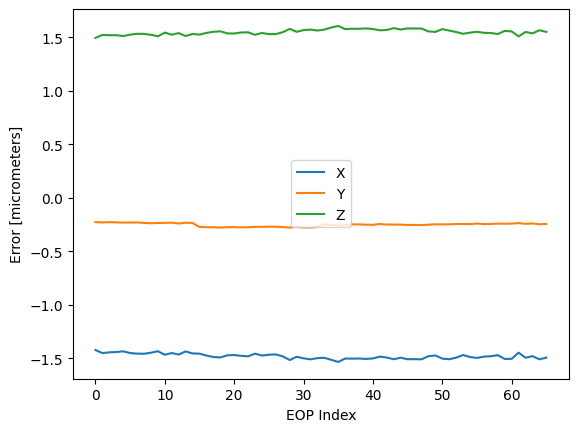

In [25]:
for axis in range(3):
    plt.plot(1_000_000 * (eop["xyz"][:, axis] - camera_xyz[:, axis]), label="XYZ"[axis])

plt.legend()
plt.xlabel("EOP Index")
plt.ylabel("Error [micrometers]")
plt.show()

In [26]:
def compare_rotation_matrices(r1, r2):
    R_relative = r1.swapaxes(-1, -2) @ r2
    trace = np.trace(R_relative, axis1=-2, axis2=-1)
    theta = np.arccos((trace - 1) / 2)
    return np.rad2deg(theta)

In [37]:
device_xyz = hilbert_lib.interpolate(eop["time"], trajectory["time"], trajectory["xyz"])
device_rot = hilbert_lib.interpolate(eop["time"], trajectory["time"], trajectory[["heading", "pitch", "roll"]])

R_device_camera = compute_rotation_matrix(*np.deg2rad(DEVICE_MOUNTING_OPK_DEG + CAMERA_MISALIGNMENT_OPK_DEG)[::-1])
R_undocumented_misalignment = compute_rotation_matrix(*np.deg2rad(CAMERA_UNDOCUMENTED_MISALIGNMENT_OPK_DEG)[::-1])

R_enu_camera = (
    R_enu_ned @
    compute_rotation_matrix(device_rot)
    @ R_device_camera
    @ R_undocumented_misalignment 
)

camera_rotation_opk = R.from_matrix(R_enu_camera).as_euler("zyx")

angular_error_deg = compare_rotation_matrices(eop_rot, R_enu_camera)

comparison_table = np.stack([
        *np.rad2deg(camera_rotation_opk.T),
        *[eop[x] for x in ["omega", "phi", "kappa"][::-1]],
        angular_error_deg,
    ], axis=-1)

# plt.plot(angular_error_deg_orig)
# plt.plot(angular_error_deg)

# comparison_table = comparison_table.astype(np.float32)
# print((comparison_table[:, 3] - comparison_table[:, 0]) / (np.nextafter(comparison_table[:, 0], np.inf) - comparison_table[:, 0]))

pd.DataFrame(comparison_table.astype(np.float32), columns=["My Kappa", "My Phi", "My Omega", "EOP Kappa", "EOP Phi", "EOP Omega", "Angular error [deg]"])


,My Kappa,My Phi,My Omega,EOP Kappa,EOP Phi,EOP Omega,Angular error [deg]
0,-89.510323,-0.001856,-0.092359,-89.510338,-0.001856,-0.092366,0.000021
1,-89.508888,-0.010682,-0.075210,-89.508888,-0.010682,-0.075218,0.000010
2,-89.509239,-0.011040,-0.076314,-89.509224,-0.011040,-0.076321,0.000015
3,-89.500244,0.003234,-0.072418,-89.500275,0.003234,-0.072425,0.000032
4,-89.510201,-0.001002,-0.079481,-89.510231,-0.001002,-0.079488,0.000031
...,...,...,...,...,...,...,...
61,90.472412,0.004583,0.091289,90.472397,0.004583,0.091296,0.000018
62,90.468849,0.006187,0.072488,90.468834,0.006186,0.072495,0.000019
63,90.466789,0.004460,0.094593,90.466774,0.004460,0.094600,0.000014
64,90.469604,0.003843,0.094962,90.469582,0.003842,0.094970,0.000027


# Tie Points

In [38]:
tie_points_xyz, tie_points = hilbert_lib.read_tie_points(TIE_POINTS_PATH, n_images=N_IMAGES)

In [39]:
pd.DataFrame(tie_points_xyz, columns=["X", "Y", "Z"])

,X,Y,Z
0,4263313.173700,725883.927600,4672955.139700
1,4264667.446400,726149.426300,4671690.614000
2,4263379.229500,725457.338200,4672952.537200
3,4263834.220600,725539.241000,4672540.707300
4,4264259.730000,725663.543800,4672134.717300
...,...,...,...
334,4263112.671800,734949.615300,4672149.875300
335,4263078.925000,734528.840700,4672106.197200
336,4263100.037200,734183.719600,4672075.320100
337,4263522.142300,734811.928000,4671805.977200


In [40]:
data_frame(tie_points)

,point_idx,image_idx,xy[0],xy[1]
0,0,0,1544.000000,1807.000000
1,0,65,12572.160000,8774.360000
2,0,64,12566.130000,4556.910000
3,0,1,1566.750000,6070.730000
4,1,33,4077.210000,1709.150000
...,...,...,...,...
1255,338,12,11034.740000,2054.700000
1256,338,48,1778.620000,2651.000000
1257,338,52,3185.620000,4966.740000
1258,338,14,11024.800000,9182.200000


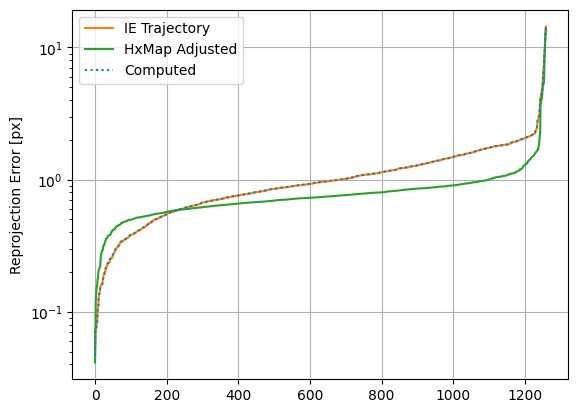

In [41]:
camera_data = [
    (eop["xyz"], eop_rot, "IE Trajectory", "C1-"),
    (eop_adjusted["xyz"], eop_adjusted_rot, "HxMap Adjusted", "C2-"),
    (camera_xyz, R_enu_camera, "Computed", "C0:"),
]

for cameras, cameras_rot, plot_label, plot_color in camera_data:
    R_ecef_camera = (
        compute_base_ecef_rotation(device_xyz) @  # Slightly wrong, should recompute device_xyz using camera xyz
        cameras_rot @
        np.diag([1, -1, -1])  # Modify camera coordinate convention from OpenGL (right, up, backward) to custom (right, down, forward)
    )
    
    R_camera_ecef = R_ecef_camera.swapaxes(-2, -1)
    
    local_xyz = tie_points_xyz[tie_points["point_idx"]] - cameras[tie_points["image_idx"]]
    projected_xy = CAMERA_MATRIX @ R_camera_ecef[tie_points["image_idx"]] @ local_xyz[..., np.newaxis]
    projected_xy = projected_xy[..., 0]
    projected_xy = projected_xy[..., :-1] / projected_xy[..., -1:]
    
    reprojection_errors = np.linalg.norm(projected_xy - tie_points["xy"], axis=-1)
    
    plt.plot(sorted(reprojection_errors), plot_color, label=plot_label)
    plt.ylabel("Reprojection Error [px]")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)

# pd.DataFrame(np.stack([tie_points["point_idx"], tie_points["image_idx"], reprojection_errors], axis=-1)[reprojection_errors > 10])

# LiDAR

In [32]:
# I believe data in .las files is not sorted using time; internally in read_las we have explicit array.sort() call.
# Only predefined fields are read by this call, ignoring some of other available (like number of returns, return number, intensity).
point_cloud = hilbert_lib.read_las(ROOT / "las_ecef" / f"{FLIGHT_NAME}.las", sort=True)[:500_000]
data_frame(point_cloud)

,xyz[0],xyz[1],xyz[2],time,laser_vector[0],laser_vector[1],laser_vector[2],range_time
0,4262865.985000,734029.356000,4672326.271000,480155.739986,-0.106446,0.488967,-0.865783,14685.089844
1,4262866.324000,734029.527000,4672325.945000,480155.739986,-0.106669,0.488918,-0.865783,14685.047852
2,4262867.048000,734030.230000,4672326.293000,480155.739987,-0.106887,0.488871,-0.865783,14678.716797
3,4262869.193000,734033.159000,4672329.960000,480155.739987,-0.106887,0.488871,-0.865783,14644.286133
4,4262867.448000,734030.494000,4672326.101000,480155.739988,-0.107102,0.488824,-0.865783,14677.527344
...,...,...,...,...,...,...,...,...
499995,4262241.836000,734223.140000,4673042.503000,480155.922321,0.331051,0.374922,-0.865932,13654.703125
499996,4262241.404000,734222.336000,4673041.822000,480155.922322,0.330865,0.375087,-0.865932,13661.500977
499997,4262242.430000,734223.034000,4673042.386000,480155.922322,0.330865,0.375087,-0.865932,13652.406250
499998,4262234.126000,734217.390000,4673037.820000,480155.922322,0.330865,0.375087,-0.865932,13726.011719


In [40]:
point_index = 30_000

point_cloud_sample = point_cloud[point_index:point_index+1]
timestamps = point_cloud_sample["time"]

lidar_xyz = hilbert_lib.interpolate(timestamps, trajectory["time"], trajectory["xyz"] + lidar_lever_arm_in_ecef)
lidar_rot = hilbert_lib.interpolate(timestamps, trajectory["time"], trajectory[["heading", "pitch", "roll"]])

R_device_lidar = compute_rotation_matrix(*np.deg2rad(DEVICE_MOUNTING_OPK_DEG + LIDAR_MISALIGNMENT_OPK_DEG)[::-1])

R_ecef_enu = compute_base_ecef_rotation(lidar_xyz)[0]

R_enu_lidar = (    
    R_enu_ned @
    compute_rotation_matrix(lidar_rot) @ 
    R_device_lidar
)[0]

laser_vector = point_cloud_sample["laser_vector"][0]
laser_vector_in_enu = R_enu_lidar @ laser_vector

def raycast_no_atmospheric_model(ray_origin, ray_direction, time_of_flight):
    assert abs(np.linalg.norm(ray_direction) - 1) < 1e-6
    
    light_speed_in_air = 299_792_458.0 * 0.9997
    return ray_origin + time_of_flight * ray_direction * light_speed_in_air

# Assumes linear model for light speed
def raycast_no_refraction(ray_origin, ray_direction, time_of_flight):
    assert abs(np.linalg.norm(ray_direction) - 1) < 1e-6

    altitude0 = ray_origin[2]
    initial_light_speed = light_speed_in_air(altitude0)

    slope = light_speed_in_air(altitude0 + ray_direction[2]) - initial_light_speed

    distance = initial_light_speed * (np.exp(slope * time_of_flight) - 1) / slope
    return ray_origin + ray_direction * distance

def raycast(ray_origin, ray_direction, time_of_flight, time_step=1e-9):
    assert abs(np.linalg.norm(ray_direction) - 1) < 1e-6

    point = ray_origin.copy()
    ray_direction = ray_direction.copy()

    while time_of_flight > 0:
        if time_of_flight <= time_step:
            time_step = time_of_flight
            time_of_flight = 0
        else:
            time_of_flight -= time_step

        altitude = point[2]
        change_vector = time_step * light_speed_in_air(altitude) * ray_direction
        point += change_vector

        refractive_index = refractive_index_in_air(altitude)
        delta_altitude = 1e-6
        refractive_index_gradient = (refractive_index_in_air(altitude + delta_altitude) - refractive_index) / delta_altitude

        # Update the z-component of the direction
        delta_z = (refractive_index_gradient / refractive_index) * np.linalg.norm(change_vector)
        ray_direction += (0, 0, delta_z)
        ray_direction = ray_direction / np.linalg.norm(ray_direction)
        
    return point

In [41]:
origin_xyz = np.array([0, 0, compute_wgs84_altitude(lidar_xyz)[0]])
reference_point_xyz = origin_xyz + R_ecef_enu.T @ (point_cloud_sample["xyz"][0] - lidar_xyz[0])

point_xyz = raycast_no_atmospheric_model(
                origin_xyz,
                laser_vector_in_enu,
                1e-9 * point_cloud_sample["range_time"][0] / 2
            )

print("In ENU (no atmospheric model)")
print("  Calculated point position = ", point_xyz)
print("     (distance)             = ", np.linalg.norm(origin_xyz - point_xyz))
print("  HxMap point position      = ", reference_point_xyz)
print("     (distance)             = ", np.linalg.norm(origin_xyz - reference_point_xyz))
print("  Difference                = ", (reference_point_xyz - point_xyz))
print("  Difference length         = ", np.linalg.norm(reference_point_xyz - point_xyz))
print("     (distance difference)  = ", np.linalg.norm(origin_xyz - point_xyz) - np.linalg.norm(origin_xyz - reference_point_xyz))
print()

point_xyz = raycast_no_refraction(
                origin_xyz,
                laser_vector_in_enu,
                1e-9 * point_cloud_sample["range_time"][0] / 2
            )

print("In ENU (no refraction)")
print("  Calculated point position = ", point_xyz)
print("     (distance)             = ", np.linalg.norm(origin_xyz - point_xyz))
print("  HxMap point position      = ", reference_point_xyz)
print("     (distance)             = ", np.linalg.norm(origin_xyz - reference_point_xyz))
print("  Difference                = ", (reference_point_xyz - point_xyz))
print("  Difference length         = ", np.linalg.norm(reference_point_xyz - point_xyz))
print("     (distance difference)  = ", np.linalg.norm(origin_xyz - point_xyz) - np.linalg.norm(origin_xyz - reference_point_xyz))
print()

point_xyz = raycast(
                origin_xyz,
                laser_vector_in_enu,
                1e-9 * point_cloud_sample["range_time"][0] / 2
            )

print("In ENU:")
print("  Calculated point position = ", point_xyz)
print("     (distance)             = ", np.linalg.norm(origin_xyz - point_xyz))
print("  HxMap point position      = ", reference_point_xyz)
print("     (distance)             = ", np.linalg.norm(origin_xyz - reference_point_xyz))
print("  Difference                = ", (reference_point_xyz - point_xyz))
print("  Difference length         = ", np.linalg.norm(reference_point_xyz - point_xyz))
print("     (distance difference)  = ", np.linalg.norm(origin_xyz - point_xyz) - np.linalg.norm(origin_xyz - reference_point_xyz))
print()

point_xyz = lidar_xyz[0] + R_ecef_enu @ (point_xyz - origin_xyz)

print("In ECEF:")
print("  Calculated point position = ", point_xyz)
print("  HxMap point position      = ", point_cloud_sample["xyz"][0])
print("  Difference                = ", (point_cloud_sample["xyz"][0] - point_xyz))
print("  Difference length         = ", np.linalg.norm(point_cloud_sample["xyz"][0] - point_xyz))

In ENU (no atmospheric model)
  Calculated point position =  [-817.82441883 -771.52623467  583.52120547]
     (distance)             =  2245.42649141886
  HxMap point position      =  [-817.84566748 -771.54068659  583.40398312]
     (distance)             =  2245.540665666246
  Difference                =  [-0.02124865 -0.01445193 -0.11722235]
  Difference length         =  0.1200060120512377
     (distance difference)  =  -0.11417424738556292

In ENU (no refraction)
  Calculated point position =  [-817.86583521 -771.5653064   583.42277391]
     (distance)             =  2245.5402046052986
  HxMap point position      =  [-817.84566748 -771.54068659  583.40398312]
     (distance)             =  2245.540665666246
  Difference                =  [ 0.02016773  0.02461981 -0.01879079]
  Difference length         =  0.036958975915515536
     (distance difference)  =  -0.0004610609471455973

In ENU:
  Calculated point position =  [-817.84602801 -771.54662052  583.40706077]
     (distance)     